In [291]:
import numpy as np
import pandas as pd

In [292]:
# Load and prepare Feb 4 data - FIXED VERSION
def load_yield_data(filepath, target_date):
    """Properly load and process yield curve data"""
    df = pd.read_csv(filepath)
    data_on_date = df[df['Date'] == target_date].copy()  # Explicit copy
    
    maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
    
    # Use .loc to avoid SettingWithCopyWarning
    for mat in maturities:
        time_col = f'Time_{mat}'
        yield_col = f'Yield_{mat}'
        
        if time_col in data_on_date.columns:
            data_on_date.loc[:, time_col] = pd.to_numeric(data_on_date[time_col], errors='coerce')
        if yield_col in data_on_date.columns:
            data_on_date.loc[:, yield_col] = pd.to_numeric(data_on_date[yield_col], errors='coerce')
    
    # Filter valid data points
    valid_cols = [f'Time_{mat}' for mat in maturities if f'Time_{mat}' in data_on_date.columns] + \
                 [f'Yield_{mat}' for mat in maturities if f'Yield_{mat}' in data_on_date.columns]
    data_on_date = data_on_date.dropna(subset=valid_cols)
    
    times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
    yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100
    
    valid_idx = ~np.isnan(times) & ~np.isnan(yields)
    return times[valid_idx], yields[valid_idx]



In [293]:
# Load Jan 31st data
times_jan31, yields_jan31 = load_yield_data(
    '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv', 
    '2025-01-31'
)

In [294]:
# Load STRIPS data
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
dt = '2025-01-31'  # Changed to January 31, 2025
data_on_date = df[df['Date'] == dt]
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
times_jan31 = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
yields_jan31 = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100  # Convert to percentage
valid_idx = ~np.isnan(times_jan31) & ~np.isnan(yields_jan31)
times_jan31 = times_jan31[valid_idx]
yields_jan31 = yields_jan31[valid_idx]

In [295]:
yields_jan31

array([3.694, 4.066, 4.158, 4.157, 4.294, 4.368, 4.425, 4.457, 4.493,
       4.525, 4.701, 4.159, 4.1  , 3.948, 4.246, 4.176, 4.379, 4.444,
       4.477, 4.515, 4.402, 4.489, 4.589, 4.639, 4.221, 4.208, 4.214,
       4.258, 4.304, 4.332, 4.409, 4.447, 4.487, 4.517, 4.524, 4.582,
       4.688, 4.22 , 3.867, 4.172, 4.278, 4.363, 4.44 , 4.442, 4.493,
       4.531])

In [296]:
# Two-Factor Vasicek Model (with adjusted yield curve formula)
class Two_Factor_Vasicek:
    def __init__(self, x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2):
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.mu1 = mu1
        self.mu2 = mu2
        self.vol1 = vol1
        self.vol2 = vol2
        self.var1 = vol1**2
        self.var2 = vol2**2
        self.kappa1 = kappa1
        self.kappa2 = kappa2
    
    def B(self, tau, kappa):
        return (1 - np.exp(-kappa * tau)) / kappa if kappa > 1e-6 else tau  # Avoid division by zero
    
    def A(self, tau, mu, var, kappa):
        B_tau = self.B(tau, kappa)
        return (mu - var / (2 * kappa**2)) * (B_tau - tau) - (var * B_tau**2) / (4 * kappa)
    
    def yield_curve(self, tau, r_t):
        if tau <= 0:
            return np.nan
        A1 = self.A(tau, self.mu1, self.var1, self.kappa1)
        A2 = self.A(tau, self.mu2, self.var2, self.kappa2)
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        price = np.exp(A1 + A2 - (B1 + B2) * r_t)
        price = max(price, 1e-10)
        return -np.log(price) / tau
    
    def update_params(self, x):
        self.x1_0 = max(x[0], 0)
        self.x2_0 = max(x[1], 0)
        self.mu1 = x[2]
        self.mu2 = x[3]
        self.vol1 = max(x[4], 1e-6)
        self.vol2 = max(x[5], 1e-6)
        self.var1 = self.vol1**2
        self.var2 = self.vol2**2
        self.kappa1 = max(x[6], 1e-6)
        self.kappa2 = max(x[7], 1e-6)

    def simulate_paths(self, T, dt, n_paths):
        n_steps = int(T / dt)
        times = np.linspace(0, T, n_steps + 1)
        r_paths = np.zeros((n_paths, n_steps + 1))
        x1 = np.zeros((n_paths, n_steps + 1))
        x2 = np.zeros((n_paths, n_steps + 1))
        x1[:, 0] = self.x1_0
        x2[:, 0] = self.x2_0
        r_paths[:, 0] = x1[:, 0] + x2[:, 0]

        for t in range(1, n_steps + 1):
            dW1 = np.random.normal(0, np.sqrt(dt), n_paths)
            dW2 = np.random.normal(0, np.sqrt(dt), n_paths)
            x1[:, t] = x1[:, t-1] + self.kappa1 * (self.mu1 - x1[:, t-1]) * dt + self.vol1 * dW1
            x2[:, t] = x2[:, t-1] + self.kappa2 * (self.mu2 - x2[:, t-1]) * dt + self.vol2 * dW2
            r_paths[:, t] = np.maximum(x1[:, t] + x2[:, t], 0)

        return times, r_paths

In [297]:
from scipy.optimize import least_squares

In [298]:
# Fitter Class
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)  # Observed yields in decimal
        self.times = np.array(obs_times)
        self.dist = dist
        self.model_yields = None
        self.n_params = 8

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        r0 = m.x1_0 + m.x2_0
        
        # Calculate model yields
        model_yields = np.array([m.yield_curve(t, r0) for t in self.times])
        residuals = model_yields - self.data
        
        # Use time-weighted scheme - emphasize short-term yields more
        weights = 1 / (1 + self.times)  # Higher weight for shorter maturities
        
        # Additional weight for the first 3 maturities
        weights[:3] *= 2
        
        weighted_residuals = residuals * weights
        
        # Improved penalty terms
        short_term_penalty = 1000 * (model_yields[0] - self.data[0])**2  # Exact match for shortest maturity
        level_penalty = 100 * (np.mean(model_yields) - np.mean(self.data))**2  # Match average level
        convexity_penalty = 50 * ((model_yields[-1] - model_yields[0]) - (self.data[-1] - self.data[0]))**2  # Match curve steepness
        
        # Regularization to prevent extreme parameters
        reg_penalty = 0.01 * np.sum(x**2)
        
        total_penalty = short_term_penalty + level_penalty + convexity_penalty + reg_penalty
        
        return np.append(weighted_residuals, total_penalty)
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)
        ss_res = np.sum((self.data - self.model_yields) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def fit(self, x0, solver='trf', bounds=None):
        if bounds is not None:
            lower_bounds, upper_bounds = zip(*bounds)
            bounds_for_least_squares = (list(lower_bounds), list(upper_bounds))
        else:
            bounds_for_least_squares = ([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], 
                                       [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

        result = least_squares(self.residuals, x0, method=solver, bounds=bounds_for_least_squares)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t, self.model.x1_0 + self.model.x2_0) for t in self.times])
        return result

In [299]:
# Fit the model with adjusted parameters and bounds
model = Two_Factor_Vasicek(0.01847, 0.01847, 0.0225, 0.0225, 0.005, 0.005, 0.05, 0.05)
yields_jan31_decimal = yields_jan31 / 100  # Convert to decimal for fitting
fitter = Fitter(model, yields_jan31_decimal, times_jan31)
x0 = [
    0.02,       # x1_0
    0.02,       # x2_0
    0.025,      # mu1
    0.025,      # mu2
    0.01,       # vol1
    0.01,       # vol2
    0.5,        # kappa1 (faster mean reversion)
    0.1         # kappa2 (slower mean reversion)
]

bounds = [
        (0.01, 0.03),    # x1_0 (short rate component)
        (0.01, 0.03),    # x2_0 (long rate component)
        (0.015, 0.04),   # mu1 (long-term mean 1)
        (0.015, 0.04),   # mu2 (long-term mean 2)
        (0.001, 0.02),   # vol1 (volatility 1)
        (0.001, 0.02),   # vol2 (volatility 2)
        (0.05, 1.0),     # kappa1 (mean reversion 1) - faster for short rate
        (0.01, 0.3)      # kappa2 (mean reversion 2) - slower for long rate
]

fit_result = fitter.fit(x0, solver='trf', bounds=bounds)
model.update_params(fit_result.x)
print("Calibrated parameters [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]:", fit_result.x)

Calibrated parameters [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]: [0.01       0.01       0.03198236 0.04       0.001      0.001
 0.05002284 0.02376126]


In [300]:
# Check the fitted yield curve at t=0
fitted_yields_jan31 = np.array([model.yield_curve(t, model.x1_0 + model.x2_0) * 100 for t in times_jan31])
print("Fitted yields at t=0 (Jan 31, 2025):", fitted_yields_jan31)
print("Observed yields (Jan 31, 2025):", yields_jan31)

Fitted yields at t=0 (Jan 31, 2025): [4.02862657 4.08085512 4.13171691 4.18139155 4.22965154 4.27667651
 4.3225069  4.36730245 4.41085582 4.45332689 4.65071391 4.00220539
 4.05512923 4.10666296 4.15685318 4.20587683 4.29992689 4.34516992
 4.3893956  4.43239897 4.51524546 4.55526306 4.59420318 4.6322067
 4.01524085 4.06782133 4.11902324 4.16902756 4.21760542 4.2649378
 4.31106557 4.35614961 4.39998139 4.44272195 4.564846   4.603555
 4.6413346  4.04192244 4.09380208 4.14432665 4.19367441 4.28833932
 4.33387482 4.37838425 4.42166149 4.46386527]
Observed yields (Jan 31, 2025): [3.694 4.066 4.158 4.157 4.294 4.368 4.425 4.457 4.493 4.525 4.701 4.159
 4.1   3.948 4.246 4.176 4.379 4.444 4.477 4.515 4.402 4.489 4.589 4.639
 4.221 4.208 4.214 4.258 4.304 4.332 4.409 4.447 4.487 4.517 4.524 4.582
 4.688 4.22  3.867 4.172 4.278 4.363 4.44  4.442 4.493 4.531]


In [301]:
import matplotlib.pyplot as plt

In [302]:
# Get metrics from the fitter
r2 = fitter.r_squared()
rmse = fitter.rmse()

# Create formatted strings for legend
metrics_text = f'$R^2$: {r2:.2f}\nRMSE: {rmse*100:.2f}%'

print(metrics_text)

$R^2$: 0.74
RMSE: 0.11%


In [315]:
def plot_yield_comparison(times, yields=None, fitted=None, forecast=None, historical=None,
                         metrics_text=None, title=None, figsize=(16, 10), dpi=100):
    """
    Unified function to plot yield curve comparisons for both fitting and forecasting scenarios.
    
    Parameters:
    - times: Array of maturity times
    - yields: Array of observed yields (optional)
    - fitted: Array of fitted yields (for fitting plots)
    - forecast: Dict with forecast stats (for forecasting plots) OR array of mean forecast values
    - historical: List of dicts with historical series to plot
    - metrics_text: String containing metrics to display
    - title: Plot title
    - figsize: Figure dimensions
    - dpi: Figure resolution
    """
    # Sort all data by maturity
    sorted_idx = np.argsort(times)
    times_sorted = times[sorted_idx]
    
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot observed yields if provided
    if yields is not None:
        yields_sorted = yields[sorted_idx]
        obs_plot = plt.plot(times_sorted, yields_sorted, 'o-',
                           label='Observed Yields',
                           color='#1f77b4', linewidth=2,
                           markersize=8, markerfacecolor='white',
                           markeredgewidth=2)
    
    # Plot fitted yields if provided (fitting scenario)
    if fitted is not None:
        fitted_sorted = fitted[sorted_idx]
        fit_plot = plt.plot(times_sorted, fitted_sorted, 's--',
                           label='Fitted Yields',
                           color='#d62728', linewidth=2,
                           markersize=6, alpha=0.9)
    
    # Plot forecast if provided (forecasting scenario)
    if forecast is not None:
        # Handle both dict and array inputs for forecast
        if isinstance(forecast, dict):
            fcst_mean = forecast['mean']
            fcst_lower = forecast.get('lower', None)
            fcst_upper = forecast.get('upper', None)
        else:
            fcst_mean = forecast
            fcst_lower = None
            fcst_upper = None
        
        fcst_mean_sorted = fcst_mean[sorted_idx]
        fcst_plot = plt.plot(times_sorted, fcst_mean_sorted, 'D-',
                            label='Forecasted Yields',
                            color='#2ca02c', linewidth=2.5,
                            markersize=7, alpha=0.9)
        
        # Confidence band if available
        if fcst_lower is not None and fcst_upper is not None:
            plt.fill_between(times_sorted,
                            fcst_lower[sorted_idx],
                            fcst_upper[sorted_idx],
                            color='#2ca02c', alpha=0.15,
                            label=f"{forecast["confidence"]*100} % Confidence Band")
    
    # Plot historical series if provided
    if historical is not None:
        for series in historical:
            hist_times = series['times']
            hist_yields = series['yields']
            hist_sorted_idx = np.argsort(hist_times)
            plt.plot(hist_times[hist_sorted_idx], hist_yields[hist_sorted_idx],
                    series.get('marker', 'o'),
                    label=series.get('label', 'Historical'),
                    color=series.get('color', '#7f7f7f'),
                    markersize=8, linestyle='none')
    
    # Create legends
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Main legend for yield curves
    if handles:  # Only add legend if there are items to show
        main_legend = plt.legend(handles=handles, loc='upper right',
                               fontsize=12, framealpha=1)
        plt.gca().add_artist(main_legend)
    
    # Add metrics text if provided
    if metrics_text is not None:
        metrics_patch = plt.Line2D([0], [0], marker='', color='none',
                                 label=metrics_text,
                                 markerfacecolor='white', markersize=0)
        plt.legend(handles=[metrics_patch], loc='lower left',
                 fontsize=12, handlelength=0, handletextpad=0,
                 framealpha=0.7)
    
    # Formatting
    plt.xlabel('Time to Maturity (Years)', fontsize=14, labelpad=10)
    plt.ylabel('Yield (%)', fontsize=14, labelpad=10)
    plt.title(title or 'Yield Curve Comparison', fontsize=16, pad=15)
    
    # Dynamic axis limits
    y_values = []
    if yields is not None:
        y_values.extend(yields)
    if fitted is not None:
        y_values.extend(fitted)
    if forecast is not None:
        if isinstance(forecast, dict):
            y_values.extend(forecast['mean'])
            if 'lower' in forecast:
                y_values.extend(forecast['lower'])
            if 'upper' in forecast:
                y_values.extend(forecast['upper'])
        else:
            y_values.extend(forecast)
    
    if y_values:
        y_min = min(y_values)
        y_max = max(y_values)
        plt.ylim(max(0, y_min-0.5), y_max + 0.5)
    
    # Grid and spines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    # Ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='minor', length=3)
    
    plt.tight_layout()
    plt.show()

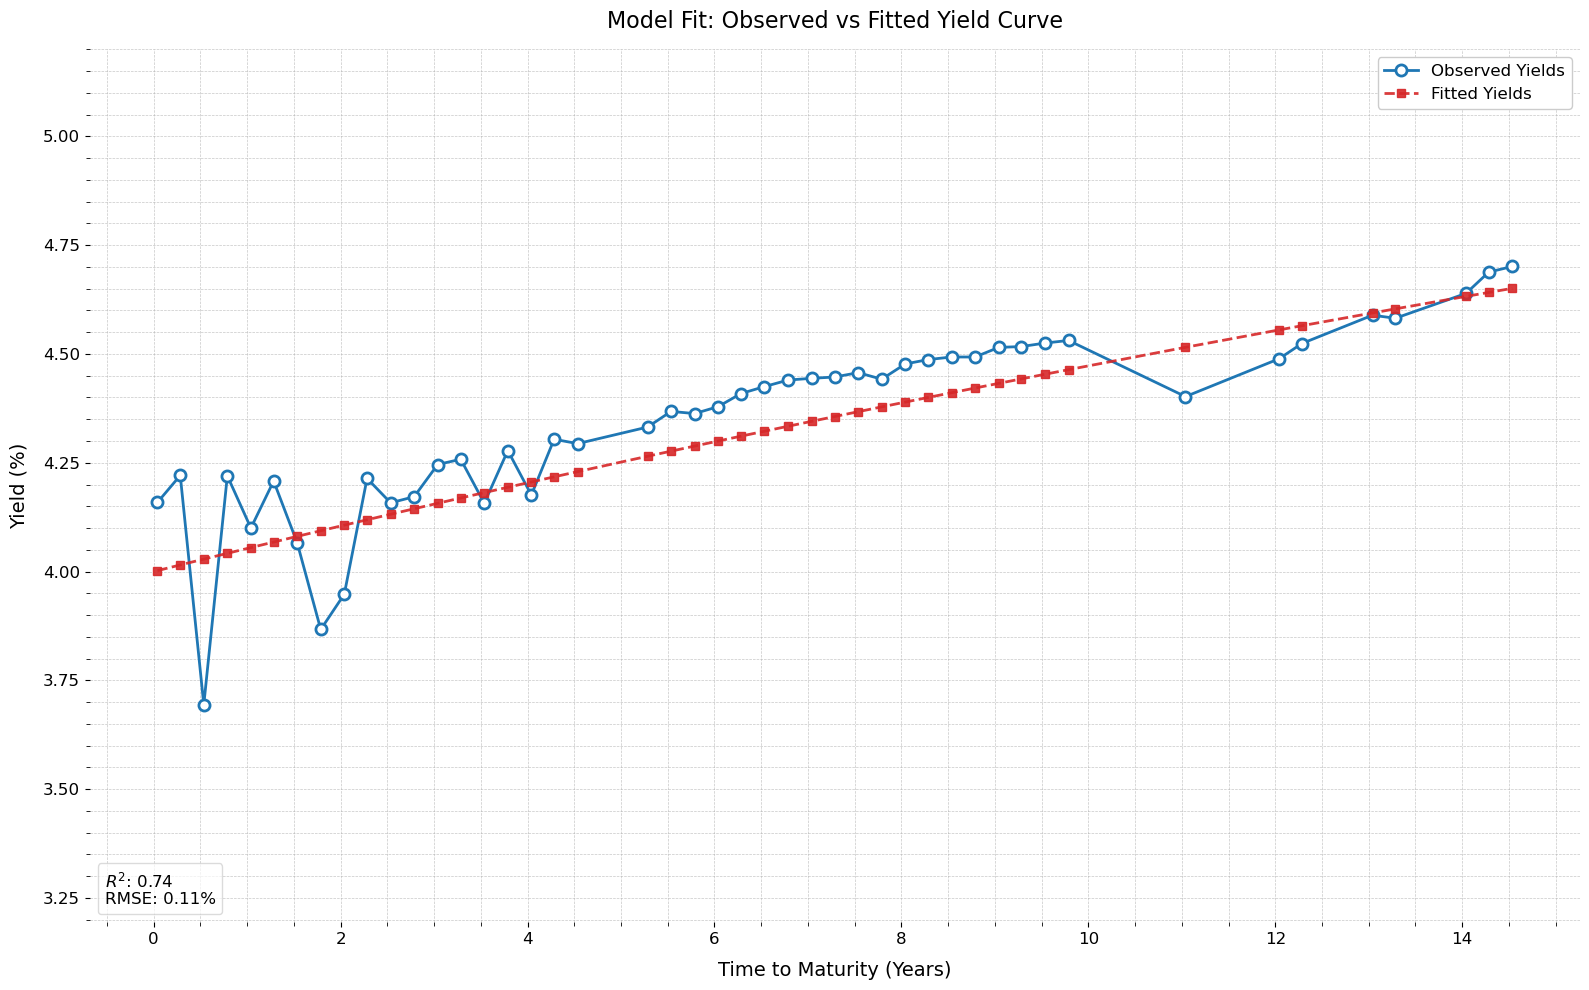

In [304]:
# For fitting plot on Jan 31, 2025 data
plot_yield_comparison(
    times=times_jan31,
    yields=yields_jan31,
    fitted=fitted_yields_jan31,
    metrics_text=metrics_text,
    title='Model Fit: Observed vs Fitted Yield Curve'
)

In [305]:
# Load Feb 4 data
times_feb04, yields_feb04 = load_yield_data(
    '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv', 
    '2025-02-04'
)
observed_yields_feb4 = yields_feb04


In [306]:
observed_yields_feb4

array([3.694, 4.088, 4.169, 4.157, 4.289, 4.354, 4.403, 4.431, 4.464,
       4.495, 4.658, 2.52 , 4.081, 3.973, 4.252, 4.173, 4.357, 4.419,
       4.448, 4.483, 4.371, 4.451, 4.548, 4.597, 4.204, 4.221, 4.222,
       4.262, 4.299, 4.317, 4.387, 4.419, 4.458, 4.487, 4.486, 4.544,
       4.645, 4.243, 3.887, 4.182, 4.277, 4.345, 4.417, 4.409, 4.464,
       4.499])

In [326]:
# Forecasting function
def generate_forecast(model, maturities, T=4/365, dt=1/252, n_paths=5000, confidence=0.8):
    """Generate forecast with fixed key names for confidence intervals"""
    times_sim, r_paths = model.simulate_paths(T, dt, n_paths)
    forecast = np.array([[model.yield_curve(t, r_paths[i,-1])*100 for t in maturities] 
                       for i in range(n_paths)])
    
    lower_pct = int((1-confidence)*50)
    upper_pct = int(100 - (1-confidence)*50)
    
    return {
        'mean': np.mean(forecast, axis=0),
        'median': np.median(forecast, axis=0),
        'lower': np.percentile(forecast, lower_pct, axis=0),  # Fixed key
        'upper': np.percentile(forecast, upper_pct, axis=0),  # Fixed key
        'std': np.std(forecast, axis=0),
        'confidence': confidence,
        'paths': forecast
    }


In [308]:
from scipy.optimize import minimize

In [309]:
# Forecasting and optimization function
def forecast_and_optimize(model, observed_yields, maturities, T=4/365, dt=1/252, n_paths=5000):
    """Optimize model parameters to match observed yields"""
    
    def objective(params):
        """Objective function for optimization"""
        model.update_params(params)
        forecast = generate_forecast(model, maturities, T, dt, 1000)  # Fewer paths for speed
        
        errors = forecast['mean'] - observed_yields
        mse = np.mean(errors**2)
        shape_error = np.mean((np.diff(forecast['mean']) - np.diff(observed_yields))**2)
        reg_penalty = 0.001 * np.sum(params**2)
        
        return mse + 0.3*shape_error + reg_penalty
    
    # Parameter bounds
    bounds = [
        (0.005, 0.03), (0.005, 0.03),       # x1_0, x2_0
        (0.01, 0.04), (0.01, 0.04),         # mu1, mu2
        (0.0001, 0.02), (0.0001, 0.02),     # vol1, vol2
        (0.05, 1.5), (0.01, 0.5)            # kappa1, kappa2
    ]
    
    initial_params = [
        model.x1_0, model.x2_0, 
        model.mu1, model.mu2,
        model.vol1, model.vol2,
        model.kappa1, model.kappa2
    ]
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={
            'maxiter': 50,
            'ftol': 1e-6,
            'gtol': 1e-5,
            'disp': True
        }
    )
    
    model.update_params(result.x)
    final_forecast = generate_forecast(model, maturities, T, dt, n_paths)
    
    # Calculate metrics
    errors = final_forecast['mean'] - observed_yields
    metrics = {
        'RMSE': np.sqrt(np.mean(errors**2)),
        'MAE': np.mean(np.abs(errors)),
        'Max Error': np.max(np.abs(errors)),
        'params': dict(zip(
            ['x1_0', 'x2_0', 'mu1', 'mu2', 'vol1', 'vol2', 'kappa1', 'kappa2'],
            result.x
        ))
    }
    
    return metrics, final_forecast


In [310]:
# Load data
times_feb04, yields_feb04 = load_yield_data('STRIPS_data.csv', '2025-02-04')

print(f"Matruities_Feb, {times_feb04}")
print(f"Yields_Feb, {yields_feb04}")

Matruities_Feb, [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.27241615  0.77754962  1.77686516  2.7761807   3.77823409  5.77686516
  6.7761807   7.77823409  8.77754962  9.77686516]
Yields_Feb, [3.694 4.088 4.169 4.157 4.289 4.354 4.403 4.431 4.464 4.495 4.658 2.52
 4.081 3.973 4.252 4.173 4.357 4.419 4.448 4.483 4.371 4.451 4.548 4.597
 4.204 4.221 4.222 4.262 4.299 4.317 4.387 4.419 4.458 4.487 4.486 4.544
 4.645 4.243 3.887 4.182 4.277 4.345 4.417 4.409 4.464 4.499]


In [311]:
# Run optimization
metrics, forecast = forecast_and_optimize(
    model, 
    yields_feb04, 
    times_feb04
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13924D-02    |proj g|=  4.76239D-01

At iterate    1    f=  9.13826D-02    |proj g|=  2.00000D-02

At iterate    2    f=  9.13674D-02    |proj g|=  2.19824D-02

At iterate    3    f=  9.13690D-02    |proj g|=  4.76239D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      3     19     10     0     0   4.762D-01   9.137D-02
  F =   9.1369031767486800E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


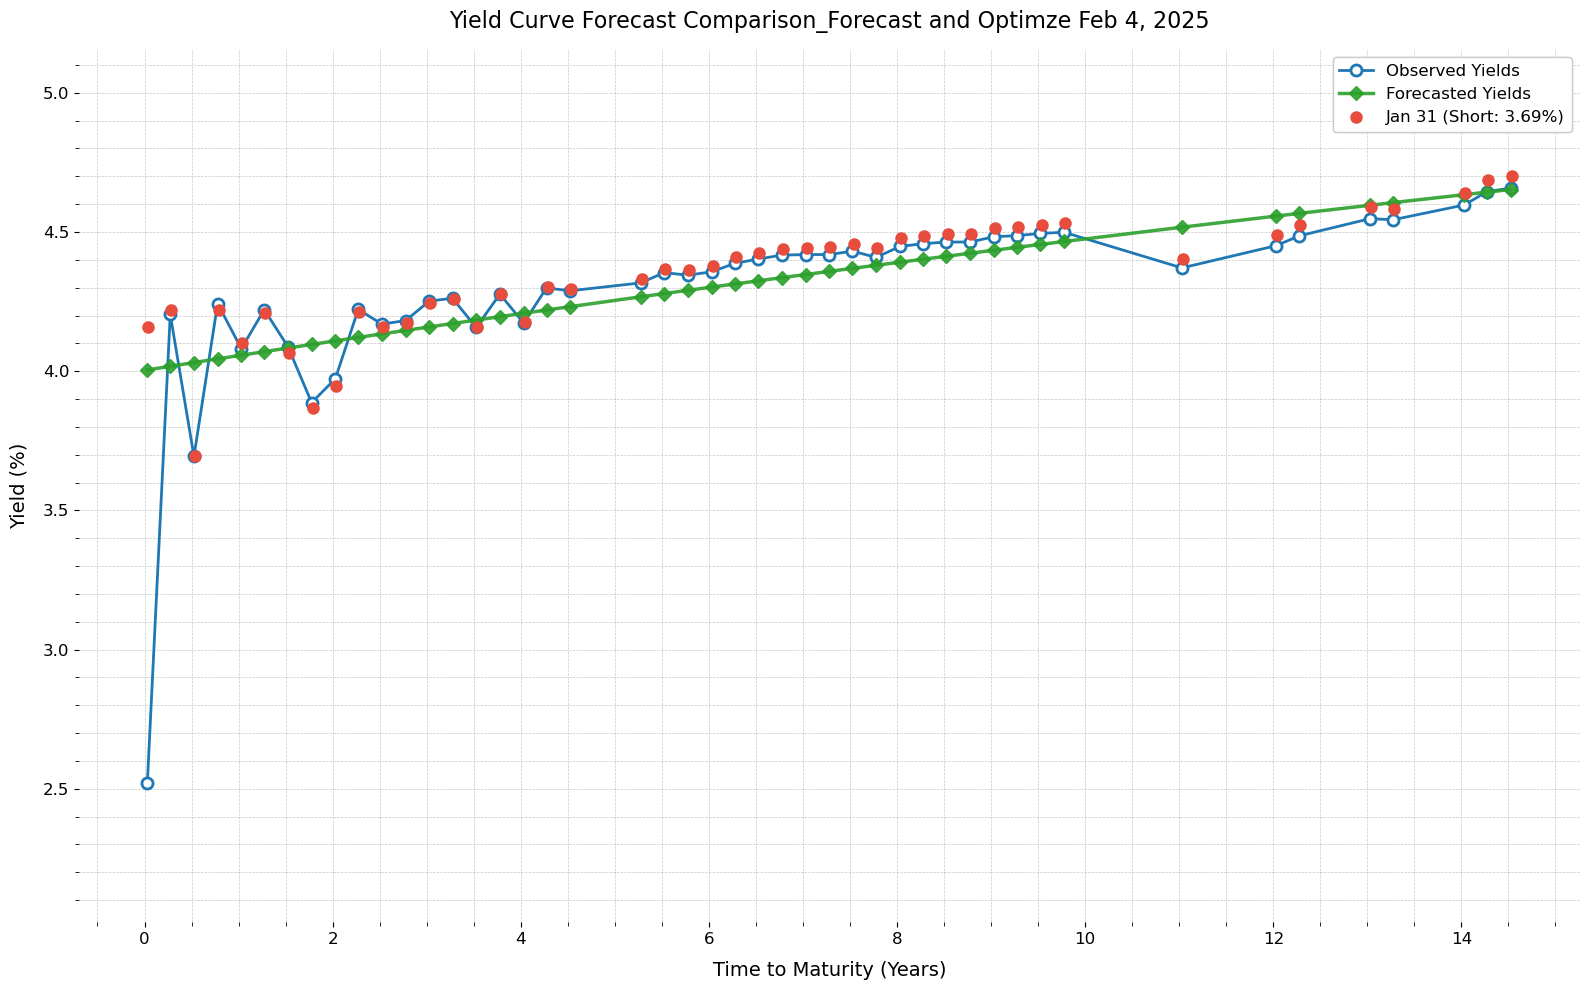

In [312]:
plot_yield_comparison(
    times=times_feb04,
    yields=yields_feb04,  
    forecast=forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31,
         'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)',
         'color': '#e74c3c', 'marker': 'o'},
    ],
    title='Yield Curve Forecast Comparison_Forecast and Optimze Feb 4, 2025',
)

In [332]:
# Forecast yields for March 4, 2025

def forecast_yields(model, times_jan31, yields_jan31, observed_yields_feb4,
                   forecast_maturities=None, T=32/365, dt=1/252, n_paths=5000):
    """Forecast yields using consistent key names"""
    if forecast_maturities is None:
        forecast_maturities = np.linspace(0.1, 15, 40)
    
    forecast_stats = generate_forecast(model, forecast_maturities, T, dt, n_paths)
    
    forecast_df = pd.DataFrame({
        'Maturity': forecast_maturities,
        'Mean_Yield': forecast_stats['mean'],
        'Median_Yield': forecast_stats['median'],
        f'Lower_{int((1-forecast_stats["confidence"])*50)}th': forecast_stats['lower'],
        f'Upper_{int(100-(1-forecast_stats["confidence"])*50)}th': forecast_stats['upper'],
        'Std_Dev': forecast_stats['std']
    })
    
    return forecast_stats, forecast_df

In [333]:
# Generate March 4 forecast
forecast_stats_mar4, forecast_df_mar4 = forecast_yields(
        model, 
        times_jan31, 
        yields_jan31, 
        observed_yields_feb4,
        T=32/365  # 32 days from Jan 31 to Mar 4
    )

In [334]:
forecast_stats_mar4

{'mean': array([4.03689125, 4.05703896, 4.0769819 , 4.09672273, 4.11626408,
        4.13560854, 4.15475864, 4.17371691, 4.1924858 , 4.21106775,
        4.22946514, 4.24768034, 4.26571566, 4.28357338, 4.30125576,
        4.318765  , 4.3361033 , 4.35327281, 4.37027562, 4.38711385,
        4.40378952, 4.42030468, 4.43666131, 4.45286137, 4.46890681,
        4.48479952, 4.50054138, 4.51613424, 4.53157992, 4.54688023,
        4.56203693, 4.57705176, 4.59192644, 4.60666267, 4.62126211,
        4.63572641, 4.65005719, 4.66425606, 4.67832457, 4.69226429]),
 'median': array([4.03674163, 4.05689039, 4.07683436, 4.09657622, 4.11611858,
        4.13546405, 4.15461515, 4.1735744 , 4.19234427, 4.21092718,
        4.22932553, 4.24754166, 4.26557792, 4.28343656, 4.30111986,
        4.31863001, 4.33596921, 4.3531396 , 4.37014329, 4.38698239,
        4.40365892, 4.42017493, 4.43653241, 4.45273331, 4.46877957,
        4.48467309, 4.50041576, 4.51600943, 4.53145591, 4.546757  ,
        4.56191448, 4.576930

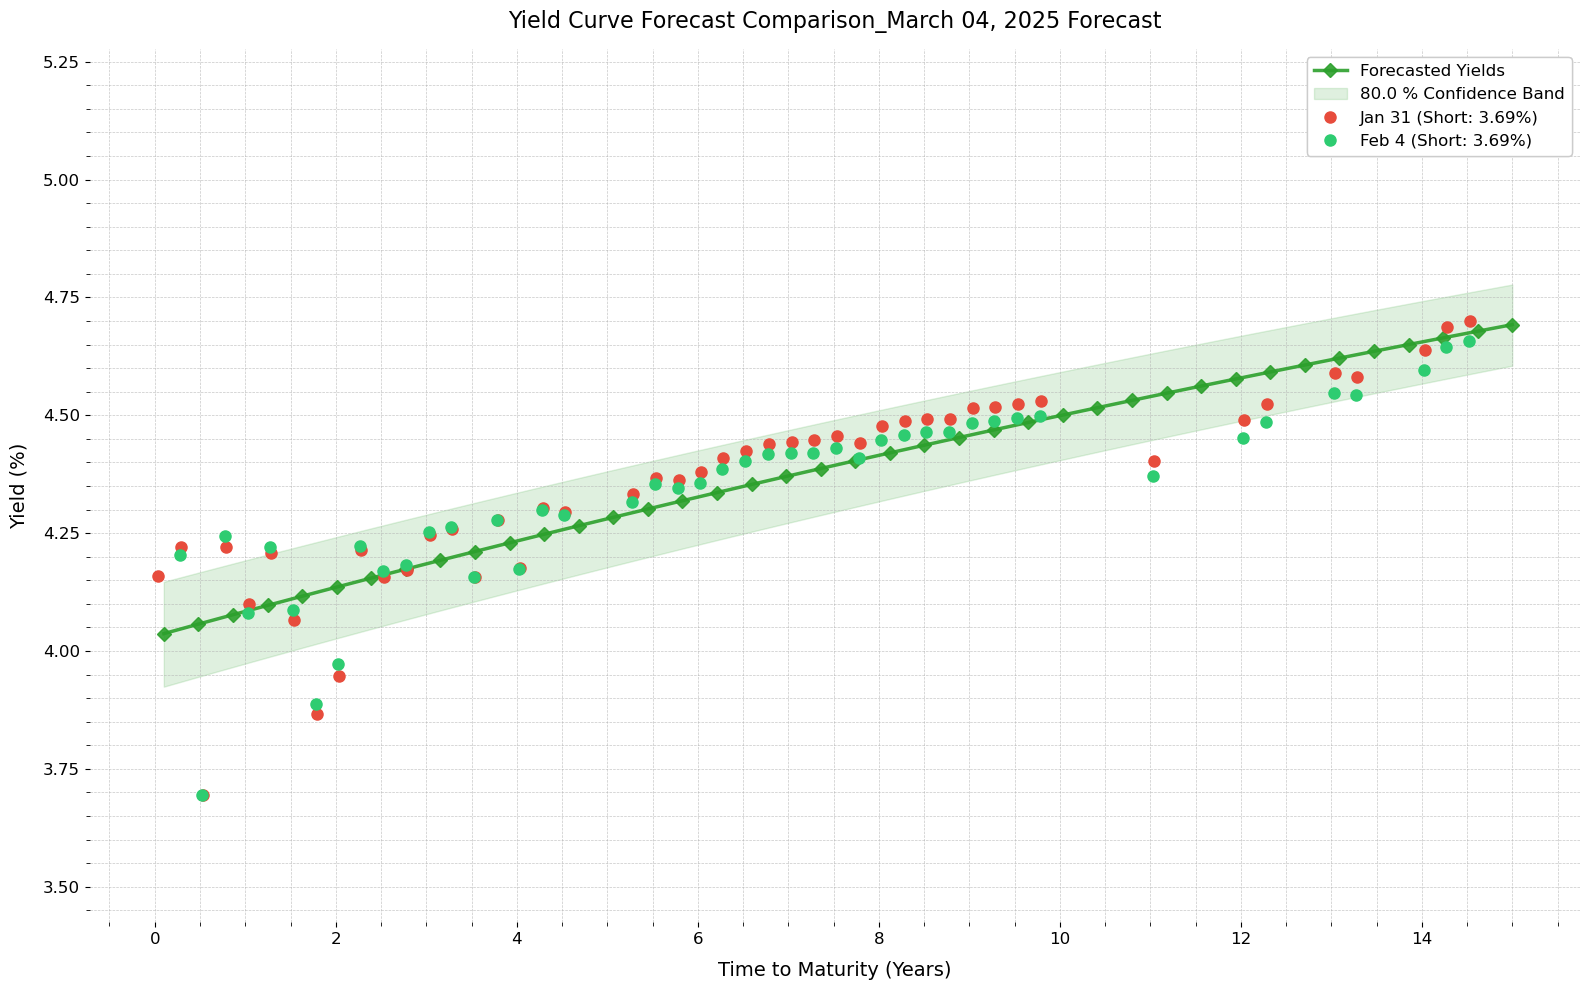

In [335]:
# Plot forecast for March 4, 2025

plot_yield_comparison(
    times=forecast_df_mar4['Maturity'],
    forecast={
        'mean': forecast_stats_mar4['mean'],
        'lower': forecast_stats_mar4['lower'],
        'upper': forecast_stats_mar4['upper'],
        'confidence': forecast_stats_mar4['confidence']
    },
    historical=[
        {'times': times_jan31, 'yields': yields_jan31,
         'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)',
         'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04,
         'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)',
         'color': '#2ecc71', 'marker': 'o'}
    ],
    title='Yield Curve Forecast Comparison_March 04, 2025 Forecast'
)

In [336]:
# Save results
forecast_df_mar4.to_csv('vasicek_forecast_march4.csv', index=False)
print("March 4 forecast saved to CSV")

March 4 forecast saved to CSV


In [337]:
# Generate April 4 forecast
forecast_stats_apr4, forecast_df_apr4 = forecast_yields(
    model, 
    times_jan31, 
    yields_jan31, 
    observed_yields_feb4,
    T=64/365  # 64 days from Jan 31 to Apr 4
    )

In [338]:
forecast_df_apr4

,Maturity,Mean_Yield,Median_Yield,Lower_9th,Upper_90th,Std_Dev
0,0.100000,4.065601,4.063267,3.912527,4.216887,0.116359
1,0.482051,4.085547,4.083230,3.933545,4.235774,0.115544
2,0.864103,4.105291,4.102991,3.954350,4.254469,0.114738
3,1.246154,4.124835,4.122551,3.974944,4.272976,0.113940
4,1.628205,4.144182,4.141913,3.995329,4.291296,0.113150
5,2.010256,4.163333,4.161080,4.015509,4.309432,0.112369
6,2.392308,4.182293,4.180055,4.035485,4.327385,0.111596
7,2.774359,4.201062,4.198840,4.055261,4.345160,0.110830
8,3.156410,4.219644,4.217437,4.074840,4.362757,0.110073
9,3.538462,4.238041,4.235849,4.094223,4.380180,0.109324


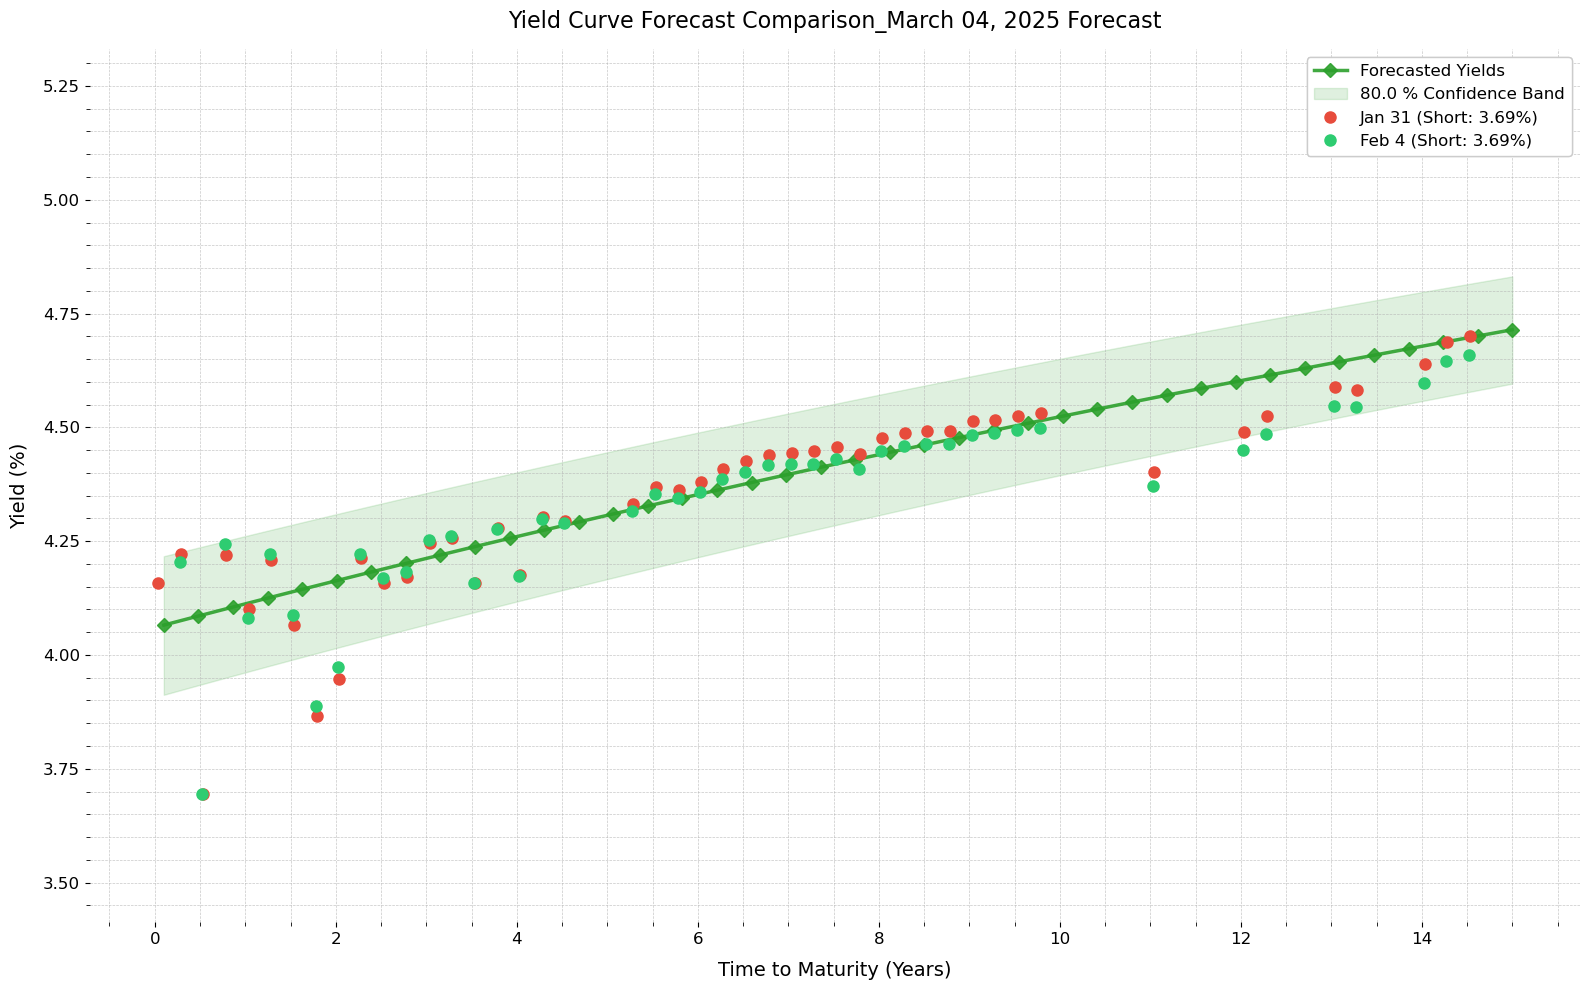

In [339]:
# Plot forecast for April 4, 2025

plot_yield_comparison(
    times=forecast_df_apr4['Maturity'],
    forecast={
        'mean': forecast_stats_apr4['mean'],
        'lower': forecast_stats_apr4['lower'],
        'upper': forecast_stats_apr4['upper'],
        'confidence': forecast_stats_apr4['confidence']
    },
    historical=[
        {'times': times_jan31, 'yields': yields_jan31,
         'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)',
         'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04,
         'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)',
         'color': '#2ecc71', 'marker': 'o'}
    ],
    title='Yield Curve Forecast Comparison_March 04, 2025 Forecast'
)